In [8]:
# Import OS libraries
import os
import json
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
from sklearn.model_selection import train_test_split

In [9]:
# Import OS libraries
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold

In [10]:
# Import OS libraries
import os
import itertools

# Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report


# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,  BatchNormalization, Activation, Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

# from googleapiclient.discovery import build
# from google.oauth2.credentials import Credentials
# from googleapiclient.http import MediaFileUpload

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


# Check GPU availability
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

sns.set_style('whitegrid')

GPU is not available


In [11]:
# Directory where images are stored without being separated by folders
image_dir = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset'

In [12]:
#load image, resize, normalise and convert 
def load_image(image_path, target_size=(112, 112)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)
        return np.array(image) / 255.0  # Normaliza a imagem para a faixa [0, 1]
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

In [13]:
# Path to the file IDs of the images with dark backgrounds
ids_dark = r'C:\Users\bruna\OneDrive - Universidade do Minho\Microbialdataset\dark_images_ids.txt'

# Load training group IDs from a text file
with open(ids_dark, 'r') as file:
    ids = [line.strip() for line in file.readlines()]

In [14]:
#number of ids loaded 
print(f"Número de IDs carregados: {len(ids)}")
print(f"Primeiros 5 IDs: {ids[:5]}")

Número de IDs carregados: 9649
Primeiros 5 IDs: ['10000', '10001', '10002', '10003', '10004']


In [15]:
# Split the IDs into training and validation (e.g. 80 per cent for training and 20 per cent for validation)
split_index = int(len(ids) * 0.8)
train_ids = ids[:split_index]
val_ids = ids[split_index:]

In [16]:
%%capture
# Lists for storing image paths and corresponding labels
train_data = []
val_data = []

# Iterate over all the files in the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.json'):
        json_path = os.path.join(image_dir, filename)
        with open(json_path, 'r') as file:
            try:
                json_data = json.load(file)
            except json.JSONDecodeError as e:
                print(f"Erro ao carregar JSON {json_path}: {e}")
                continue

        sample_id = str(json_data.get('sample_id', None))
        if sample_id is None:
            print(f"ID da amostra ausente no JSON: {json_path}")
            continue

        image_filename = f"{sample_id}.jpg"
        image_path = os.path.join(image_dir, image_filename)
        if not os.path.exists(image_path):
            print(f"Arquivo de imagem não encontrado: {image_path}")
            continue

        classes = json_data.get('classes', [])
        if not classes:
            print(f"Chave 'classes' ausente ou vazia no JSON: {json_path}")
            continue

        data_tuple = (image_path, classes[0])
        if sample_id in train_ids:
            train_data.append(data_tuple)
        elif sample_id in val_ids:
            val_data.append(data_tuple)

In [17]:
#number of images loaded in training and validation
print(f"Número de imagens no conjunto de treinamento: {len(train_data)}")
print(f"Número de imagens no conjunto de validação: {len(val_data)}")

Número de imagens no conjunto de treinamento: 7718
Número de imagens no conjunto de validação: 1930


In [18]:
# Separate image paths and labels for training and validation
train_images, train_labels = zip(*train_data)
val_images, val_labels = zip(*val_data)

In [19]:
# Convert the labels to the appropriate (numeric) format, if necessary
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)


In [20]:
# Convert the labels to one-hot encoded
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))

In [21]:
# Get the number of classes from the one hot encoder
num_classes = len(one_hot_encoder.categories_[0])
num_classes

5

In [22]:
# Function to generate batches of data
def data_generator(image_paths, labels_one_hot, batch_size=8, target_size=(112, 112)):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_paths = image_paths[start:end]
            batch_labels = labels_one_hot[start:end]
            batch_images = []
            for path in batch_paths:
                image = load_image(path, target_size)
                if image is not None:
                    batch_images.append(image)
            yield np.array(batch_images), np.array(batch_labels)

In [23]:
# Create data generators for training and validation
train_generator = data_generator(train_images, train_labels_one_hot, batch_size=8, target_size=(112, 112))
val_generator = data_generator(val_images, val_labels_one_hot, batch_size=8, target_size=(112, 112))

In [24]:
# Create the CNN model
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(112, 112, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Corrigido para usar `num_classes`
])

In [25]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 8,  # Número total de batches
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_images) // 8   # Número total de batches de validação
)

Epoch 1/10
964/964 [==============================] - 1747s 2s/step - loss: 1.5317 - accuracy: 0.2907 - val_loss: 1.6045 - val_accuracy: 0.1981
Epoch 2/10
964/964 [==============================] - 2201s 2s/step - loss: 1.4296 - accuracy: 0.3361 - val_loss: 1.6343 - val_accuracy: 0.2822
Epoch 3/10
964/964 [==============================] - 2750s 3s/step - loss: 1.3718 - accuracy: 0.3695 - val_loss: 1.7043 - val_accuracy: 0.2946
Epoch 4/10
964/964 [==============================] - 208157s 216s/step - loss: 1.3246 - accuracy: 0.4170 - val_loss: 1.6024 - val_accuracy: 0.2863
Epoch 5/10
964/964 [==============================] - 2329s 2s/step - loss: 1.2927 - accuracy: 0.4311 - val_loss: 1.5729 - val_accuracy: 0.3081
Epoch 6/10
964/964 [==============================] - 1915s 2s/step - loss: 1.2580 - accuracy: 0.4445 - val_loss: 1.5849 - val_accuracy: 0.3470
Epoch 7/10
964/964 [==============================] - 1851s 2s/step - loss: 1.2324 - accuracy: 0.4616 - val_loss: 1.6814 - val_accur

In [29]:
#save the model
model.save('trained_model.dark')

INFO:tensorflow:Assets written to: trained_model.dark\assets


INFO:tensorflow:Assets written to: trained_model.dark\assets


In [24]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('trained_model.dark')
print("Modelo carregado com sucesso!")

Modelo carregado com sucesso!


In [25]:
# Function to generate batches of data
def data_generator(image_paths, labels_one_hot, batch_size=8, target_size=(112, 112)):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_paths = image_paths[start:end]
            batch_labels = labels_one_hot[start:end]
            batch_images = []
            for path in batch_paths:
                image = load_image(path, target_size)
                if image is not None:
                    batch_images.append(image)
            yield np.array(batch_images), np.array(batch_labels)

In [26]:
# Create data generators for validation
val_generator = data_generator(val_images, val_labels_one_hot, batch_size=8, target_size=(112, 112))

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Get all the images and labels from the validation generator
val_images_all = []
val_labels_all = []
for batch_images, batch_labels in val_generator:
    val_images_all.extend(batch_images)
    val_labels_all.extend(batch_labels)
    if len(val_images_all) >= len(val_images):  
        break

In [28]:
# Converter para numpy arrays
val_images_all = np.array(val_images_all)
val_labels_all = np.array(val_labels_all)

In [29]:
# Convert to numpy arrays
np.save('val_images_all.npy', val_images_all)
np.save('val_labels_all.npy', val_labels_all)

In [30]:
# Get predictions from the model
val_predictions = model.predict(val_images_all, batch_size=8)

# Convert one-hot encoded predictions to labels
val_predictions_labels = np.argmax(val_predictions, axis=1)
val_labels_labels = np.argmax(val_labels_all, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(val_labels_labels, val_predictions_labels)
print("Matriz de Confusão:")
print(conf_matrix)

# Classification report
# Convert the values of one_hot_encoder.categories_[0] to strings
target_names = [str(int(label)) for label in one_hot_encoder.categories_[0]]
class_report = classification_report(val_labels_labels, val_predictions_labels, target_names=target_names)
print("Relatório de Classificação:")
print(class_report)

242/242 [==============================] - 5s 18ms/step
Matriz de Confusão:
[[ 21 227  40 178   2]
 [  7 294   1  15   2]
 [ 12  31 159 147  11]
 [  6  43  61 252   3]
 [  8  76  88 105 141]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.39      0.04      0.08       468
           1       0.44      0.92      0.59       319
           2       0.46      0.44      0.45       360
           3       0.36      0.69      0.47       365
           4       0.89      0.34      0.49       418

    accuracy                           0.45      1930
   macro avg       0.51      0.49      0.42      1930
weighted avg       0.51      0.45      0.40      1930



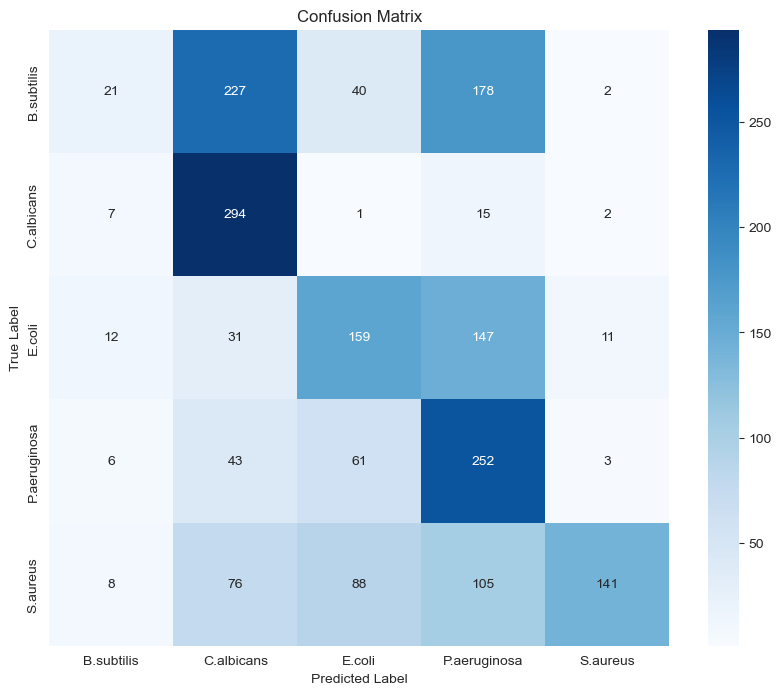

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualise the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [32]:
# Save the confusion matrix and the classification report
np.save('confusion_matrix.npy', conf_matrix)

__The model's performance for dark images is significantly lower compared to the other types of images. Especially for Class 0, the recall is very low, indicating that the model has difficulty correctly identifying this class.__

In [2]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('trained_model.dark')
print("Model successfully loaded.")


Model successfully loaded.


In [3]:
import numpy as np

# Load validation data
val_images_all = np.load('val_images_all.npy')
val_labels_all = np.load('val_labels_all.npy')

In [4]:
# Generate predictions for the validation set
val_predictions = model.predict(val_images_all, batch_size=8)

# Convert predictions from one-hot encoded to label indices
val_predictions_labels = np.argmax(val_predictions, axis=1)
val_labels_labels = np.argmax(val_labels_all, axis=1)

242/242 [==============================] - 6s 20ms/step


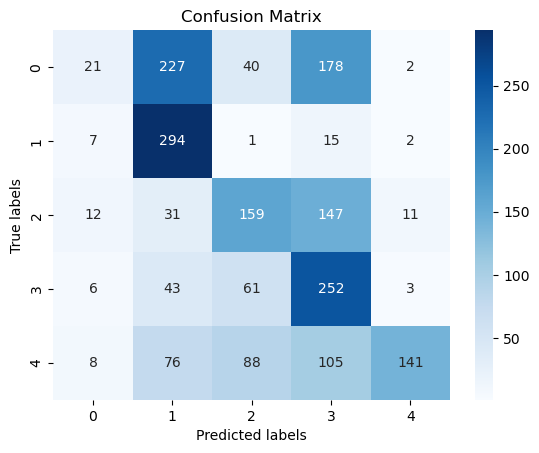

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(val_labels_labels, val_predictions_labels)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

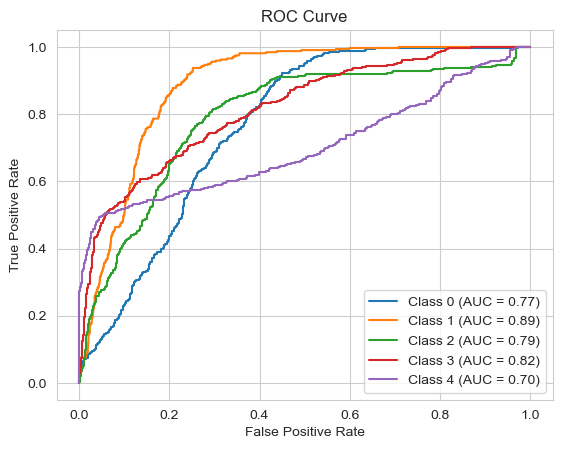

In [26]:
from sklearn.metrics import roc_curve, auc

# Plot ROC Curve for each class
for i in range(len(one_hot_encoder.categories_[0])):
    fpr, tpr, _ = roc_curve(val_labels_all[:, i], val_predictions[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc(fpr, tpr):.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

__The ROC curve indicates that the multi-class classification model performs reasonably well, based on the area under the curve (AUC) for each class.__

__As all the classes have AUCs above 0.70, the model is working well overall. AUCs close to 1 indicate a good ability of the model to separate the classes, while values close to 0.5 indicate a model that is not much better than a random choice.__
__The difference between the AUCs could be an indication of imbalance between the classes. If Class 4 has fewer examples in the dataset, the model may be having trouble learning it correctly.__

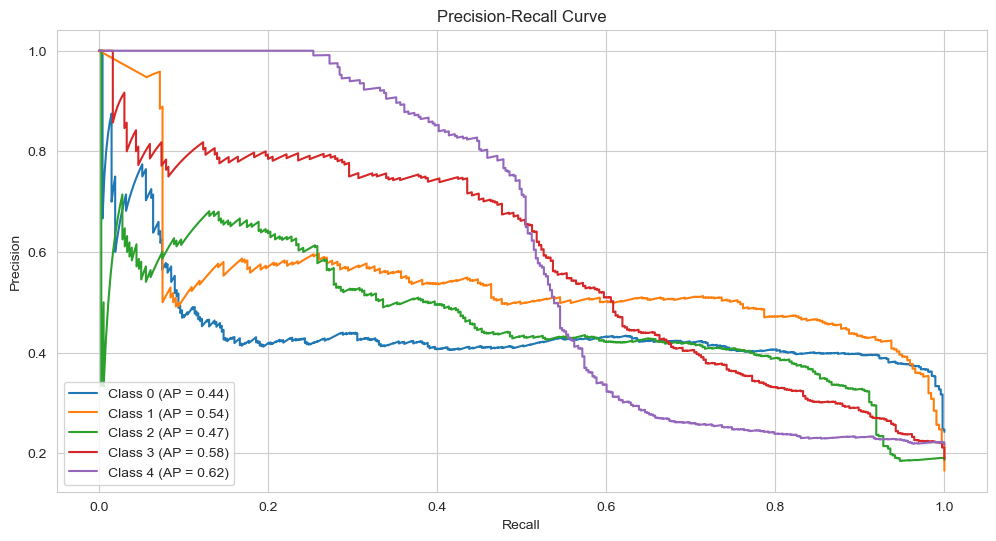

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Plot Precision-Recall Curve for each class
plt.figure(figsize=(12, 6))
for i in range(num_classes):
    # Calcular Precision, Recall e os thresholds
    precision, recall, _ = precision_recall_curve(val_labels_one_hot[:, i], val_predictions[:, i])
    # Calculate average precision
    average_precision = average_precision_score(val_labels_one_hot[:, i], val_predictions[:, i])
    # Plot Precision-Recall Curve
    plt.plot(recall, precision, label=f'Class {i} (AP = {average_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()